### ИТОГОВЫЙ ПРОЕКТ

1. Скачать данные о рынке недвижимости c открытого соревнования Сбербанка по
машинному обучению https://www.kaggle.com/c/sberbank-russian-housing-market/data.
Скачиваем только файлы train.csv.zip, macro.csv.zip и сливаем в один датафрейм.
Описание колонок - data_dictionary.txt
2. Провести чистку данных (пропуски данных, неинформативные признаки, аномалии,
оцифровка текстовых столбцов и т.п.)
3. Провести Exploratory Data Analysis. Проанализировать переменные, влияющие на
зависимую переменную - стоимость недвижимости price_doc.
4. Разделить датасет на обучающие и тестовую выборки.
5. Обучить регрессионную модель предсказывать стоимость недвижимости в
зависимости от разных факторов и выявить показатели качества модели на обучающей и
тестовой выборке.
6. Реализовать методы feature engineering с целью повышения метрик качества модели.
Результат - ссылка на готовый ноутбук в Colab с выводами.

### Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score, precision_score, recall_score,r2_score,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures,MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 
import seaborn as sns 

### Используемые функции

In [2]:
# Вывод информации о структуре датафрейма
def df_info(df):
    all_data = df.reset_index(drop=True)    
    all_data_na = (all_data.isna().sum() / len(all_data))
    missing_data = pd.DataFrame({'тип': df.dtypes})
    if len(all_data_na[all_data_na!=0])>0:
        missing_data['пропуски']= all_data_na.map("{:.1%}".format)
        display(missing_data)
        print('Столбцов с NA:',len(all_data_na[all_data_na!=0]),'из',df.shape[1])
    else:
        display(missing_data)
        print('Пропусков нет.') 
    if df.duplicated().sum()>0:
        print('Дубликатов:',df.duplicated().sum())
    else:
        print('Дубликатов нет')
    print(f'Структура : {all_data.shape}')
 
def df_mis(df):
    df=(df_all.reset_index())[mainf]
    all_data = df.reset_index(drop=True)
    print(f'all_data size is : {all_data.shape}')
    all_data_na = (all_data.isna().sum() / len(all_data)) * 100
    all_data_na = all_data_na.drop(
        all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
    missing_data
    
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    return df

# Поиск и замена пропущенных значений датафрейма по коррелируемым признакам   
def filldf(df2):
    def fgrcalc(num):
        for i in range(1,11):
            if (num>=lst[i-1] and num<=lst[i]):
                return i     
    res= pd.DataFrame(columns=['столбец','восстановлено','осталось','по_значениям','корреляция'])
    global lst
    min_cor=0.4
    df3=df2.copy()
    dfcor=df2.corr()
    for col in df2.columns:
        if (df[col].isna().sum()>0) and (col in dfcor.columns):
            na=df[col].isna().sum()
            cr=dfcor[col]
            cr_i=cr.loc[(cr>min_cor) & (cr<1)]
            cr=cr_i.index.sort_values(ascending=False).to_list()
            if len(cr)>0:                
                for i in cr:
                    if i+'_id' not in df3.columns:
                        lst=[0]+[df2[col].sort_values().to_list()[round(df2.shape[0]/10)*i-2] for i in range(1,11)]
                        df3[i+'_id']=df2[col].map(fgrcalc)                
                df2[col]=df2[col].fillna(df3.groupby([i+'_id' for i in cr])[col].transform('median'))
                df2[col]=df2[col].fillna(df3.groupby(cr)[col].transform('median'))
                for i in cr:
                    df2[col]=df2[col].fillna(df3.groupby(i)[col].transform('median'))
                res.loc[len(res.index)]=[col,na-df2[col].isna().sum(),df2[col].isna().sum(),cr,"{:.0%}".format(cr_i.max())]
    print("Значение минимальной корреляции -","{:.0%}".format(min_cor))
    display(res.sort_values(by='корреляция', ascending=False).head(50))
    return df2

### Загрузка датасета

In [3]:
df_train=pd.read_csv('train.csv')
df_macro=pd.read_csv('macro.csv')
df_all = (df_train.set_index('timestamp')).join(df_macro.set_index('timestamp'), how='inner')

In [4]:
mainf=['price_doc','id','timestamp','full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq',
       'state','product_type','sub_area']

bin_cols=['thermal_power_plant_raion','radiation_raion','big_market_raion','nuclear_reactor_raion',
       'detention_facility_raion','big_road1_1line']

coll=['usdrub','cafe_count_3000_na_price','cafe_count_2000_price_500','rts',
       'big_church_count_5000', 'full_all','male_f','mortgage_value','income_per_cap','salary_growth',
       'oil_urals','gdp_quart','deposits_value','deposits_rate','mortgage_growth','fixed_basket',
       'cafe_count_3000_price_500','cafe_avg_price_3000','office_sqm_2000','cafe_count_3000_price_1000',
       'office_sqm_1500','cafe_count_5000_price_4000','retail_trade_turnover',
       'labor_force','unemployment'#,'rent_price_4+room_bus','rent_price_3room_bus',,'salary','retail_trade_turnover_growth'
      #'rent_price_1room_bus','rent_price_3room_eco','rent_price_2room_eco','rent_price_1room_eco'
      ]

df=(df_all.reset_index())[mainf+coll+bin_cols]

### Структура датафрейма и пропуски

In [5]:
df_info(df)

,тип,пропуски
price_doc,int64,0.0%
id,int64,0.0%
timestamp,object,0.0%
full_sq,int64,0.0%
life_sq,float64,20.9%
floor,float64,0.5%
max_floor,float64,31.4%
material,float64,31.4%
build_year,float64,44.6%
num_room,float64,31.4%


Столбцов с NA: 9 из 45
Дубликатов нет
Структура : (30471, 45)


In [6]:
all_data = df.reset_index(drop=True)
print(f'all_data size is : {all_data.shape}')
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head(50)

all_data size is : (30471, 45)


,Missing Ratio
build_year,44.649011
state,44.498047
max_floor,31.413475
material,31.413475
num_room,31.413475
kitch_sq,31.413475
life_sq,20.947786
cafe_avg_price_3000,3.252273
floor,0.548062


In [7]:
missing=['provision_retail_space_modern_sqm', 'provision_retail_space_sqm',
       'students_reg_sports_share', 'theaters_viewers_per_1000_cap',
       'load_of_teachers_preschool_per_teacher', 'museum_visitis_per_100_cap',
       'hospital_beds_raion', 'cafe_avg_price_500',
       'cafe_sum_500_max_price_avg', 'cafe_sum_500_min_price_avg', 
       'preschool_quota', 'school_quota',
       'cafe_avg_price_1000', 'cafe_sum_1000_max_price_avg',
       'cafe_sum_1000_min_price_avg','modern_education_share',
       'old_education_build_share', 'build_count_before_1920',
       'build_count_panel', 'raion_build_count_with_material_info',
       'build_count_1921-1945', 'build_count_block', 'build_count_frame',
       'build_count_brick', 'build_count_monolith', 'build_count_wood',
       'build_count_foam', 'build_count_after_1995', 'build_count_1946-1970',
       'build_count_1971-1995', 'raion_build_count_with_builddate_info',
       'build_count_mix', 'build_count_slag', 'cafe_sum_1500_min_price_avg',
       'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500',
       'lodging_sqm_per_cap', 'water_pipes_share', 'baths_share',
       'sewerage_share', 'gas_share', 'old_house_share', 'average_life_exp']
#df=df.drop(missing,axis=1)

### Наличие пропусков и выбросов

In [8]:
# Проведем Exploratory Data Analysis
df.describe().T.head(50)

,count,mean,std,min,25%,50%,75%,max
price_doc,30471.0,7.123035e+06,4.780111e+06,1.000000e+05,4.740002e+06,6.274411e+06,8.300000e+06,1.111111e+08
id,30471.0,1.523792e+04,8.796502e+03,1.000000e+00,7.620500e+03,1.523800e+04,2.285550e+04,3.047300e+04
full_sq,30471.0,5.421427e+01,3.803149e+01,0.000000e+00,3.800000e+01,4.900000e+01,6.300000e+01,5.326000e+03
life_sq,24088.0,3.440327e+01,5.228573e+01,0.000000e+00,2.000000e+01,3.000000e+01,4.300000e+01,7.478000e+03
floor,30304.0,7.670803e+00,5.319989e+00,0.000000e+00,3.000000e+00,6.500000e+00,1.100000e+01,7.700000e+01
max_floor,20899.0,1.255897e+01,6.756550e+00,0.000000e+00,9.000000e+00,1.200000e+01,1.700000e+01,1.170000e+02
material,20899.0,1.827121e+00,1.481154e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00
build_year,16866.0,3.068057e+03,1.543878e+05,0.000000e+00,1.967000e+03,1.979000e+03,2.005000e+03,2.005201e+07
num_room,20899.0,1.909804e+00,8.518045e-01,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.900000e+01
kitch_sq,20899.0,6.399301e+00,2.826598e+01,0.000000e+00,1.000000e+00,6.000000e+00,9.000000e+00,2.014000e+03


Для снижения обьемов неинформативности были убраны команды предварительного анализа признаков типа value_counts, hist, scatter и пр.

In [9]:
# удаляем дубликаты
#df = df.drop_duplicates()

Посмотрим есть ли площадь свыше 200м для 1 и 2к квртир

In [114]:
df.loc[(df.full_sq>200) & (df.num_room<3)]

,price_doc,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,...,cafe_count_5000_price_4000,retail_trade_turnover,labor_force,unemployment,thermal_power_plant_raion,radiation_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,big_road1_1line
17277,37325704,17280,2014-04-11,220,176.0,8.0,12.0,4.0,2007.0,2.0,...,5,4436.8984,7087.326000,0.015000,no,no,no,no,yes,no
18341,6213200,18344,2014-05-13,634,NaN,3.0,17.0,1.0,NaN,2.0,...,0,4436.8984,7087.326000,0.015000,no,no,no,no,no,no
18669,10500000,18672,2014-05-20,209,209.0,0.0,3.0,4.0,2007.0,0.0,...,0,4436.8984,7087.326000,0.015000,no,no,no,no,no,no
22785,4725142,22788,2014-09-23,637,637.0,18.0,19.0,4.0,2016.0,2.0,...,141,4436.8984,7087.326000,0.015000,no,yes,no,no,yes,no
23715,6572700,23718,2014-10-20,603,NaN,16.0,18.0,1.0,NaN,2.0,...,0,4436.8984,7087.326000,0.015000,no,no,no,no,no,no
23896,46191272,23899,2014-10-23,218,174.0,10.0,12.0,4.0,2007.0,2.0,...,5,4436.8984,7087.326000,0.015000,no,no,no,no,yes,no
27496,44682580,27499,2015-01-24,209,NaN,37.0,1.0,1.0,2015.0,1.0,...,3,4310.1067,7067.470079,0.017708,no,no,no,no,no,no
27793,3134129,27796,2015-02-09,407,407.0,4.0,4.0,4.0,2015.0,1.0,...,57,4310.1067,7067.470079,0.017708,no,yes,no,no,no,no


Есть ли общая площадь меньше жилой

In [115]:
df.loc[df.life_sq>df.full_sq]

,price_doc,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,...,cafe_count_5000_price_4000,retail_trade_turnover,labor_force,unemployment,thermal_power_plant_raion,radiation_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,big_road1_1line
1084,6200000,1085,2012-02-06,44,281.0,6.0,NaN,NaN,NaN,NaN,...,4,3639.7151,6799.974000,0.008000,no,no,no,no,no,no
1188,6300000,1189,2012-02-14,9,44.0,3.0,NaN,NaN,NaN,NaN,...,3,3639.7151,6799.974000,0.008000,no,no,no,no,no,no
1822,5200000,1825,2012-04-09,18,38.0,NaN,NaN,NaN,NaN,NaN,...,1,3639.7151,6799.974000,0.008000,no,yes,yes,no,yes,no
1863,5900000,1866,2012-04-11,30,178.0,4.0,NaN,NaN,NaN,NaN,...,98,3639.7151,6799.974000,0.008000,no,yes,no,no,no,no
2009,5770000,2012,2012-04-25,5,40.0,5.0,NaN,NaN,NaN,NaN,...,2,3639.7151,6799.974000,0.008000,no,yes,no,no,no,no
4385,11918400,4388,2012-10-25,73,426.0,17.0,NaN,NaN,NaN,NaN,...,8,3639.7151,6799.974000,0.008000,no,no,no,no,yes,no
6336,5400000,6339,2013-03-06,37,191.0,5.0,NaN,NaN,NaN,NaN,...,1,4016.9869,6879.314000,0.017000,no,yes,no,no,no,no
6531,13801229,6534,2013-03-15,80,88.0,9.0,NaN,NaN,NaN,NaN,...,6,4016.9869,6879.314000,0.017000,no,yes,no,no,no,no
6993,6290256,6996,2013-04-03,73,77.0,10.0,NaN,NaN,NaN,NaN,...,0,4016.9869,6879.314000,0.017000,no,no,no,no,no,no
7208,6400000,7211,2013-04-10,31,195.0,5.0,NaN,NaN,NaN,NaN,...,7,4016.9869,6879.314000,0.017000,no,yes,no,no,no,no


Может ли площадь кухни быть больше общей площади

In [116]:
df.loc[df.kitch_sq>df.full_sq]

,price_doc,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,...,cafe_count_5000_price_4000,retail_trade_turnover,labor_force,unemployment,thermal_power_plant_raion,radiation_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,big_road1_1line
8056,2750000,8059,2013-05-21,11,11.0,2.0,5.0,2.0,1907.0,1.0,...,135,4016.9869,6879.314000,0.017000,no,yes,no,no,no,no
9172,5600000,9175,2013-07-12,37,19.0,9.0,10.0,1.0,2006.0,1.0,...,1,4016.9869,6879.314000,0.017000,no,yes,no,no,no,no
10368,7281225,10371,2013-09-10,79,41.0,5.0,17.0,6.0,2013.0,3.0,...,0,4016.9869,6879.314000,0.017000,no,no,no,no,no,no
11520,6300000,11523,2013-10-24,38,23.0,11.0,14.0,5.0,1971.0,2.0,...,2,4016.9869,6879.314000,0.017000,no,yes,no,no,no,no
12245,3600000,12248,2013-11-18,22,14.0,3.0,5.0,2.0,1970.0,1.0,...,4,4016.9869,6879.314000,0.017000,no,yes,no,no,no,no
13117,3650000,13120,2013-12-14,31,19.0,5.0,1.0,1.0,NaN,1.0,...,5,4016.9869,6879.314000,0.017000,no,yes,no,no,no,no
21415,3801200,21418,2014-08-11,43,43.0,3.0,1.0,1.0,2014.0,1.0,...,2,4436.8984,7087.326000,0.015000,no,no,yes,no,no,no
23216,5900000,23219,2014-10-02,43,29.0,5.0,5.0,2.0,1962.0,2.0,...,2,4436.8984,7087.326000,0.015000,yes,no,no,no,no,no
26236,3281884,26239,2014-12-11,34,16.0,2.0,17.0,2.0,2016.0,1.0,...,1,4436.8984,7087.326000,0.015000,no,no,no,no,no,no
26850,2000000,26853,2014-12-19,38,20.0,4.0,12.0,1.0,1977.0,1.0,...,2,4436.8984,7087.326000,0.015000,no,yes,no,no,no,no


Может ли этаж быть больше, чем этажей в доме

In [117]:
df.loc[df.floor>df.max_floor]

,price_doc,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,...,cafe_count_5000_price_4000,retail_trade_turnover,labor_force,unemployment,thermal_power_plant_raion,radiation_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,big_road1_1line
8216,5813760,8219,2013-05-29,58,30.0,13.0,0.0,1.0,NaN,2.0,...,0,4016.9869,6879.314000,0.017000,no,no,no,no,no,no
8268,5427640,8271,2013-05-31,93,93.0,3.0,1.0,1.0,2013.0,3.0,...,0,4016.9869,6879.314000,0.017000,no,no,no,no,no,no
8499,6000000,8502,2013-06-14,37,18.0,2.0,0.0,1.0,1979.0,1.0,...,4,4016.9869,6879.314000,0.017000,no,no,no,no,no,no
8531,3842500,8534,2013-06-17,34,15.0,7.0,0.0,6.0,NaN,1.0,...,0,4016.9869,6879.314000,0.017000,no,no,no,no,no,no
8912,3850000,8915,2013-07-03,51,30.0,5.0,0.0,1.0,1997.0,2.0,...,5,4016.9869,6879.314000,0.017000,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30398,4185400,30401,2015-06-24,52,NaN,5.0,1.0,1.0,NaN,1.0,...,0,4310.1067,7067.470079,0.017708,no,no,no,no,no,no
30400,16748512,30403,2015-06-24,75,NaN,3.0,0.0,1.0,NaN,2.0,...,51,4310.1067,7067.470079,0.017708,yes,no,no,no,no,no
30426,7127255,30429,2015-06-26,71,NaN,1.0,0.0,1.0,NaN,2.0,...,1,4310.1067,7067.470079,0.017708,yes,no,no,no,no,yes
30439,8535937,30442,2015-06-27,54,NaN,12.0,0.0,1.0,NaN,2.0,...,3,4310.1067,7067.470079,0.017708,no,no,no,no,no,no


Посмотрим общую площадь, жилую и кухни равную нулю 

In [119]:
df.loc[(df.full_sq==0) | (df.life_sq==0) | (df.kitch_sq==0)]

,price_doc,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,...,cafe_count_5000_price_4000,retail_trade_turnover,labor_force,unemployment,thermal_power_plant_raion,radiation_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,big_road1_1line
858,552312,859,2012-01-19,78,0.0,2.0,NaN,NaN,NaN,NaN,...,0,3639.7151,6799.974000,0.008000,no,no,no,no,no,no
1596,338570,1599,2012-03-20,59,0.0,5.0,NaN,NaN,NaN,NaN,...,0,3639.7151,6799.974000,0.008000,no,no,no,no,no,no
2778,675205,2781,2012-07-06,38,0.0,17.0,NaN,NaN,NaN,NaN,...,0,3639.7151,6799.974000,0.008000,no,no,no,no,no,no
3426,1438647,3429,2012-08-31,71,0.0,3.0,NaN,NaN,NaN,NaN,...,0,3639.7151,6799.974000,0.008000,no,no,no,no,no,no
3800,5049071,3803,2012-09-24,57,0.0,10.0,NaN,NaN,NaN,NaN,...,0,3639.7151,6799.974000,0.008000,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30426,7127255,30429,2015-06-26,71,NaN,1.0,0.0,1.0,NaN,2.0,...,1,4310.1067,7067.470079,0.017708,yes,no,no,no,no,yes
30428,3921840,30431,2015-06-26,41,NaN,4.0,15.0,4.0,NaN,1.0,...,2,4310.1067,7067.470079,0.017708,no,no,yes,no,no,no
30439,8535937,30442,2015-06-27,54,NaN,12.0,0.0,1.0,NaN,2.0,...,3,4310.1067,7067.470079,0.017708,no,no,no,no,no,no
30450,12610000,30453,2015-06-29,65,NaN,5.0,0.0,1.0,NaN,2.0,...,4,4310.1067,7067.470079,0.017708,no,yes,no,no,no,no


Уникальные значения по состоянию недвижимости

In [128]:
by=df['build_year'].dropna()
by.astype('int').unique()

array([    1907,     1980,     2014,     1970,     1982,     2013,
           2004,     2003,     1957,     1986,     1960,     1995,
           1979,     1975,     1987,     1962,     1969,     1993,
           1996,     1972,     2011,     1965,     2010,     1985,
           2006,     1961,     1971,     1978,     1966,     1967,
           2000,     1964,     1977,     1983,     1968,     1974,
           2008,     1959,     2007,     1984,     1976,     1997,
           1989,     1958,     1988,     2012,     1990,     1946,
           1917,     2002,     2005,     2001,     1963,     1954,
           1951,     1981,     1955,     1999,     2009,     1973,
           1994,     1998,     1992,     1950,     1956,     2015,
              0,     1932,        1,     1937,     1938,     1939,
           1991,     1934,     1935, 20052009,     1947,     1953,
           1933,     2016,     1930,     1912,     1929,        3,
           1928,     1915,     1936,     1925,     1940,     1

Уникальные значения по году строительства

In [ ]:
df['max_floor'].unique()

Уникальные значения по этажам в доме

In [122]:
df['max_floor'].unique()

array([ nan,  17.,   5.,  22.,  16.,   9.,   8.,   0.,  24.,   1.,   6.,
        10.,  25.,  14.,  12.,  18.,  23.,  20.,   7.,   4.,  30.,  11.,
         3.,  40.,   2.,  32.,  15.,  27.,  21.,  19.,  28.,  29.,  13.,
        39.,  38.,  31.,  26.,  37.,  33.,  47.,  36.,  34.,  48.,  42.,
        45.,  99.,  57.,  44., 117.,  41.])

Уникальные значения по этажу

In [129]:
df['floor'].unique()

array([ 4.,  3.,  2.,  9., 14., 10.,  5., 12., 11., 15.,  7.,  6., 24.,
        1.,  8., 16., 17., 13., 20., 18., nan, 21., 23., 19., 22., 26.,
       25., 29., 32., 27., 30., 44.,  0., 28., 38., 34., 33., 37., 31.,
       36., 41., 77.])

Скорректируем отдельные и пропущенные значения

In [11]:
df.loc[(df.full_sq>200) & (df.num_room<3),'full_sq']=df.full_sq/10
df['life_sq'] = np.where(df['life_sq'].isna(), df['full_sq'] - df['kitch_sq'], df['life_sq'])
df['life_sq'] = np.where(df['life_sq']==0, df['full_sq'] - df['kitch_sq'], df['life_sq'])
df['kitch_sq'] = np.where(df['kitch_sq'].isna(), df['full_sq'] - df['life_sq'], df['kitch_sq'])
df['kitch_sq'] = np.where(df['kitch_sq'] == 0, df['full_sq'] - df['life_sq'], df['kitch_sq'])
df['full_sq'] = np.where(df['full_sq'] == 0, df['kitch_sq'] + df['life_sq'], df['full_sq'])
df = df [ df['full_sq']>0 ]
df = df [ df['life_sq']>0 ]
df = df [ df['kitch_sq']>0 ]

Исправим выбросы

In [12]:
#df = df.loc[df['num_room'] > 0]
df['state'] = df['state'].replace(33,3)
dic4 = {20052009:2005, 0:np.nan, 1:np.nan, 2:np.nan, 3:np.nan, 20:2000, 215:2015, 4965:1965, 71:1971}
df['build_year'] = df['build_year'].replace(dic4) 
dic5 = {117:17, 99:np.nan, 0:np.nan}
df['max_floor'] = df['max_floor'].replace(dic5)

In [13]:
# бинаризация категориальных столбцов
df[bin_cols] = df[bin_cols].applymap(lambda x: 1 if x == 'yes' else 0)

Cоздаем новые фичи

In [10]:
df['timestamp']=pd.to_datetime(df['timestamp'], format='%Y-%m-%d')
df['month'] = pd.to_datetime(df['timestamp']).dt.to_period('M')

In [11]:
# рассчитаем цену 1 кв.м
df['price_per_sq'] = df['price_doc'] / df['full_sq']
agg2 = df.groupby('month')['price_per_sq'].mean()
price_index = agg2 / agg2[-1]
dic = price_index.to_dict()
df['price_index'] = df['month'].map(dic)
df['price_per_sq_const'] = df['price_per_sq'] / df['price_index']
df['m2'] = np.log1p(df['price_per_sq_const'])

In [12]:
# признаки с даты
df['dow'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['dom'] = pd.to_datetime(df['timestamp']).dt.day
df['doy'] = pd.to_datetime(df['timestamp']).dt.dayofyear
df['month'] = pd.to_datetime(df['timestamp']).dt.month
df['woy'] = pd.to_datetime(df['timestamp']).dt.weekofyear

<ipython-input-12-fac7d60902e0>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['woy'] = pd.to_datetime(df['timestamp']).dt.weekofyear


In [17]:
# Индекс доллара
df['usd_idx']=df['usdrub']/df['usdrub'].min()
df['usd_idx']

0        1.006824
1        1.005009
2        1.000000
3        1.005460
5        1.029832
           ...   
30466    1.918395
30467    1.918395
30468    1.918395
30469    1.918395
30470    1.918395
Name: usd_idx, Length: 25959, dtype: float64

Восстановим пропуски и уберем оставшиеся

In [18]:
# Восстановим данные по коррелируемым признакам
df=filldf(df)
#df = df.drop('timestamp', axis=1)

Значение минимальной корреляции - 40%


,столбец,восстановлено,осталось,по_значениям,корреляция
3,num_room,6343,6,"[price_doc, full_sq]",75%
1,max_floor,6317,97,"[floor, build_year]",57%
2,build_year,9527,590,[max_floor],57%
0,floor,0,96,[max_floor],50%


In [19]:
df['life_sq']=df['life_sq'].fillna(df.groupby('full_sq')['life_sq'].transform('median'))
df['kitch_sq']=df['kitch_sq'].fillna(df.groupby('full_sq')['kitch_sq'].transform('median'))
df['floor']=df['floor'].fillna(df.groupby('max_floor')['floor'].transform('median'))
'''df = df.drop(df.loc[df.floor>df.max_floor].index)
df = df.drop(df.loc[df.life_sq>df.full_sq].index)
df = df.drop(df.loc[df.kitch_sq>df.full_sq].index)'''

'df = df.drop(df.loc[df.floor>df.max_floor].index)\ndf = df.drop(df.loc[df.life_sq>df.full_sq].index)\ndf = df.drop(df.loc[df.kitch_sq>df.full_sq].index)'

In [20]:
# Для дальнейшей работы некоторых функций scylirn необходима очистка от пропусков, 
# а прямая замена пропусков приведет к статистически незначимой информации
df=df.dropna()

In [21]:
df = df.drop(['price_per_sq', 'month','price_per_sq_const','price_index'], axis=1)

Оптимизируем датафрейм для снижения занимаемой памяти и увеличения скорости вычислений 

In [48]:
df=optimizing_df(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16020 entries, 8056 to 30470
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   price_doc                   16020 non-null  uint32  
 1   full_sq                     16020 non-null  float32 
 2   life_sq                     16020 non-null  float32 
 3   floor                       16020 non-null  float32 
 4   max_floor                   16020 non-null  float32 
 5   build_year                  16020 non-null  float32 
 6   num_room                    16020 non-null  float32 
 7   kitch_sq                    16020 non-null  float32 
 8   state                       16020 non-null  float32 
 9   product_type                16020 non-null  category
 10  sub_area                    16020 non-null  category
 11  cafe_count_3000_na_price    16020 non-null  uint8   
 12  cafe_count_2000_price_500   16020 non-null  uint16  
 13  rts          

### Проведем категоризацию понятную для модели

In [23]:
# Категоризация признаков
#df = df.join(pd.get_dummies(df.product_type, prefix='type'))
#df = df.join(pd.get_dummies(df.sub_area, prefix='area'))
#df = df.join(pd.get_dummies(df.material, prefix='material'))
#df = df.join(pd.get_dummies(df.state, prefix='state'))
#df = df.join(pd.get_dummies(df.build_year, prefix='by'))

In [13]:
sub=pd.pivot_table(df,index='sub_area',aggfunc={'m2':['median']})
sub.set_axis(['price'], axis='columns', inplace=True)
sub=sub.sort_values(by='price',ascending=True)
sub

,price
sub_area,
Molzhaninovskoe,9.711055
Poselenie Klenovskoe,10.132319
Poselenie Rogovskoe,10.583638
Poselenie Shhapovskoe,10.790322
Poselenie Novofedorovskoe,10.857507
...,...
Gagarinskoe,12.247471
Dorogomilovo,12.322924
Zamoskvorech'e,12.382863


In [25]:
un_val=dict(enumerate(sub.index))
df['sub_id'] = df['sub_area'].map(dict(zip(un_val.values(),un_val.keys()))).astype('uint8')

Районы упорядочены и пронумерованы в порядке возрастания стоимости метров, что даст большее понимание для модели корреляции с целевым признаком. Конечно, можно было бы создать отдельный признак и присвоить ему среднюю стоимость м по району, что подняло бы показатели качества в разы, но возможно это было бы не совсем честно :) 

In [26]:
sub=pd.pivot_table(df,index='state',aggfunc={'m2':['median']})
sub.set_axis(['price'], axis='columns', inplace=True)
sub=sub.sort_values(by='price',ascending=True)
sub

,price
state,
1.0,11.559422
2.0,11.888000
3.0,11.929228
4.0,12.023569


In [27]:
sub=pd.pivot_table(df,index='material',aggfunc={'m2':['median']})
sub.set_axis(['price'], axis='columns', inplace=True)
sub=sub.sort_values(by='price',ascending=True)
sub

,price
material,
6.0,11.678573
4.0,11.769083
1.0,11.813820
5.0,11.930803
2.0,11.957736


Тут, также как и по районам пронумеруем материалы в порядке возрастания стоимости.

In [28]:
un_val=dict(enumerate(sub.index))
df['material_id'] = df['material'].map(dict(zip(un_val.values(),un_val.keys()))).astype('uint8')


In [29]:
sub=pd.pivot_table(df,index='product_type',aggfunc={'m2':['median']})
sub.set_axis(['price'], axis='columns', inplace=True)
sub=sub.sort_values(by='price',ascending=True)
sub

,price
product_type,
OwnerOccupier,11.558434
Investment,11.908091


In [30]:
un_val=dict(enumerate(sub.index))
df['material_id'] = df['product_type'].map(dict(zip(un_val.values(),un_val.keys()))).astype('uint8')

### Кластеризация данных по признакам

In [31]:
# Проведем кластеризацию года постройки по цене
scaler = MinMaxScaler()
train_cluster = df.copy()
train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['build_year', 'm2']]), columns=['build_year', 'm2'])

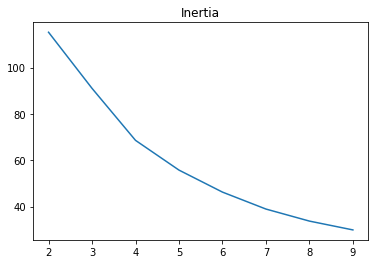

In [32]:
inertias = []
for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_cluster_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)
plt.plot(range(2, 10), inertias)
plt.title('Inertia')
plt.show()

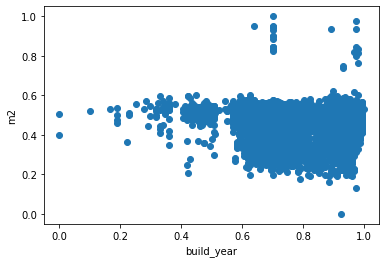

In [33]:
plt.scatter(train_cluster_scaled['build_year'], train_cluster_scaled['m2'])
plt.xlabel('build_year')
plt.ylabel('m2')
plt.show()

In [34]:
kmeans_model = KMeans(n_clusters=5, random_state=100)
train_labels = kmeans_model.fit_predict(train_cluster_scaled)

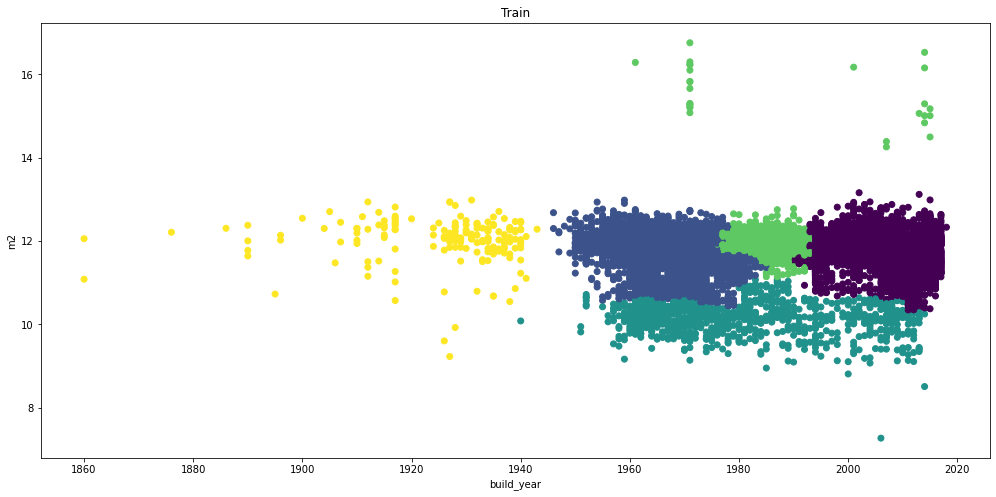

In [35]:
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)
train_cluster['cluster_year'] = agglomerative_clustering_model.fit_predict(
    train_cluster_scaled)

plt.figure(figsize=(17, 8))
plt.xlabel('build_year')
plt.ylabel('m2')
plt.title('Train')
plt.scatter(train_cluster['build_year'],
            train_cluster['m2'], c=train_cluster['cluster_year'])
plt.show()

Кластеризация не позволяет разделить года по цене, образуются категории с одинаковыми годами, 
что приведет к неоднозначности при обучении модели.

### Признаки влияющие на стоимость

<AxesSubplot:title={'center':'Степень влияния'}>

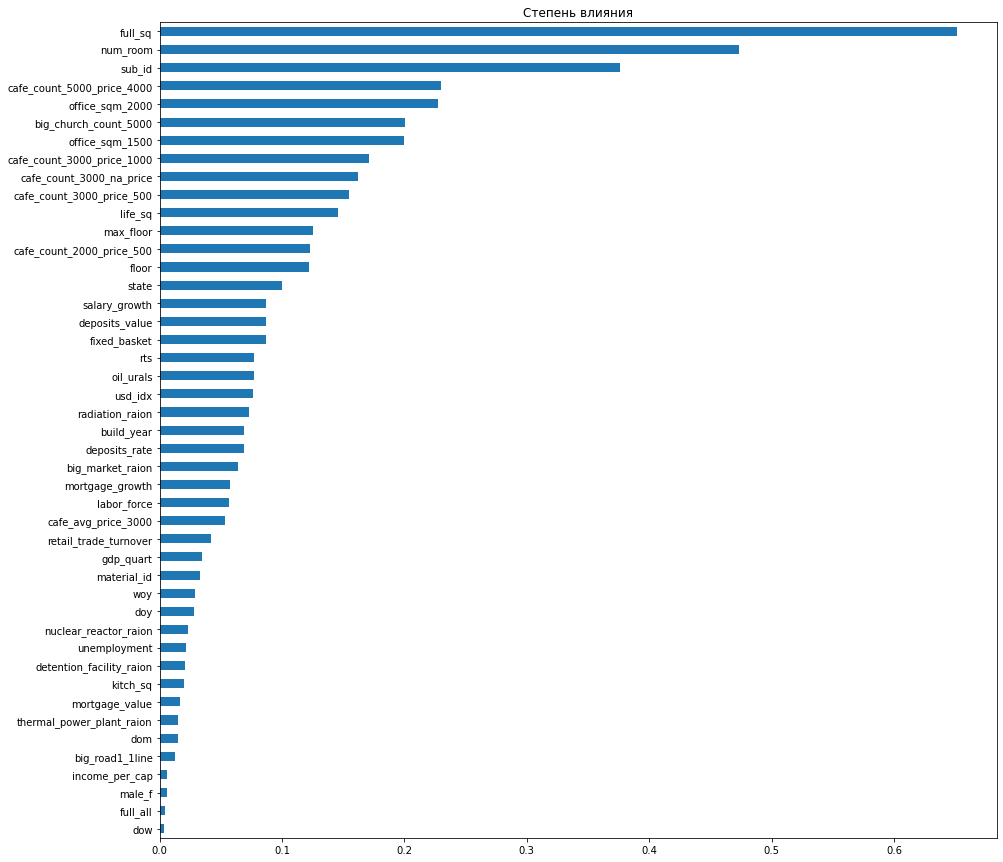

In [36]:
df=df.drop(['m2','usdrub','material','id','timestamp'],axis=1)
title="Степень влияния"
cor_param=df.corr().iloc[1:,0].abs().sort_values(ascending=True)#.iloc[:]
cor_param.plot(kind='barh',rot=0,figsize=(15,15),title=title)

На цену сильнее всего оказывает влияние общая площадь, количество комнат и район города.

### Обучение модели

Разделим признаки на обучающую и тестовую.

In [37]:
features = df.drop(['price_doc','product_type','sub_area','woy','dom','dow','doy'],axis=1)
target = df['price_doc']

In [38]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.25,\
                                                                              random_state=12345)
#features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,\
#                                                                              random_state=12345)
print(f'Размер обучающей выборки: {features_train.shape}')
print(f'Размер валидационной выборки: {features_valid.shape}')
#print(f'Размер тестовой выборки: {features_test.shape}')

Размер обучающей выборки: (12015, 41)
Размер валидационной выборки: (4005, 41)


Возьмем для сравнения модели регрессии XGBRegressor, RandomForestRegressor и GradientBoostingRegressor.

In [39]:
model = xgb.XGBRegressor(random_state=12345)
model.fit(features_train,target_train) 
print("Accuracy train:", r2_score(target_train,model.predict(features_train)))
print("Accuracy test:", r2_score(target_valid,model.predict(features_valid)))

Accuracy train: 0.9302478169237455
Accuracy test: 0.7127209550772933


In [40]:
model = RandomForestRegressor(random_state=12345)
model.fit(features_train,target_train) 
print("Accuracy train:", r2_score(target_train,model.predict(features_train)))
print("Accuracy test:", r2_score(target_valid,model.predict(features_valid)))

Accuracy train: 0.9522303716511465
Accuracy test: 0.7120071455613969


In [41]:
model = GradientBoostingRegressor(random_state=12345)
model.fit(features_train,target_train) 
print("Accuracy train:", r2_score(target_train,model.predict(features_train)))
print("Accuracy test:", r2_score(target_valid,model.predict(features_valid)))

Accuracy train: 0.7628962615267297
Accuracy test: 0.7185020997329088


Точность на проверочных данных у всех трех моделей одинаковая, совсем незначительно выделяется GradientBoostingRegressor. А вот на трейне XGBRegressor и RandomForestRegressor показывают точность близкую к 1, что может говорить о переобучении.

Используем модель GradientBoostingRegressor и проведем оптимизацию параметров через RandomizedSearchCV и GridSearchCV. 

In [75]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 21)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 15, num = 14)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 19)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 19)]
bootstrap = [True, False]
mod = GradientBoostingRegressor()
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rs = RandomizedSearchCV(mod, 
                        param_dist, 
                        n_iter = 200, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=12345)
rs.fit(features_train,target_train)
rs.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'n_estimators': 330,
 'min_samples_split': 44,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 6}

In [97]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(2)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,330,44,2,log2,6,0.676725,0.678210,0.688854,1
1,290,23,2,log2,4,0.687455,0.663159,0.687939,2


In [98]:
rs_df.mean_test_score.describe()

count    200.000000
mean       0.667366
std        0.011610
min        0.584231
25%        0.661643
50%        0.668946
75%        0.675395
max        0.688854
Name: mean_test_score, dtype: float64

Посмотрим на параметры модели влияющие на качество

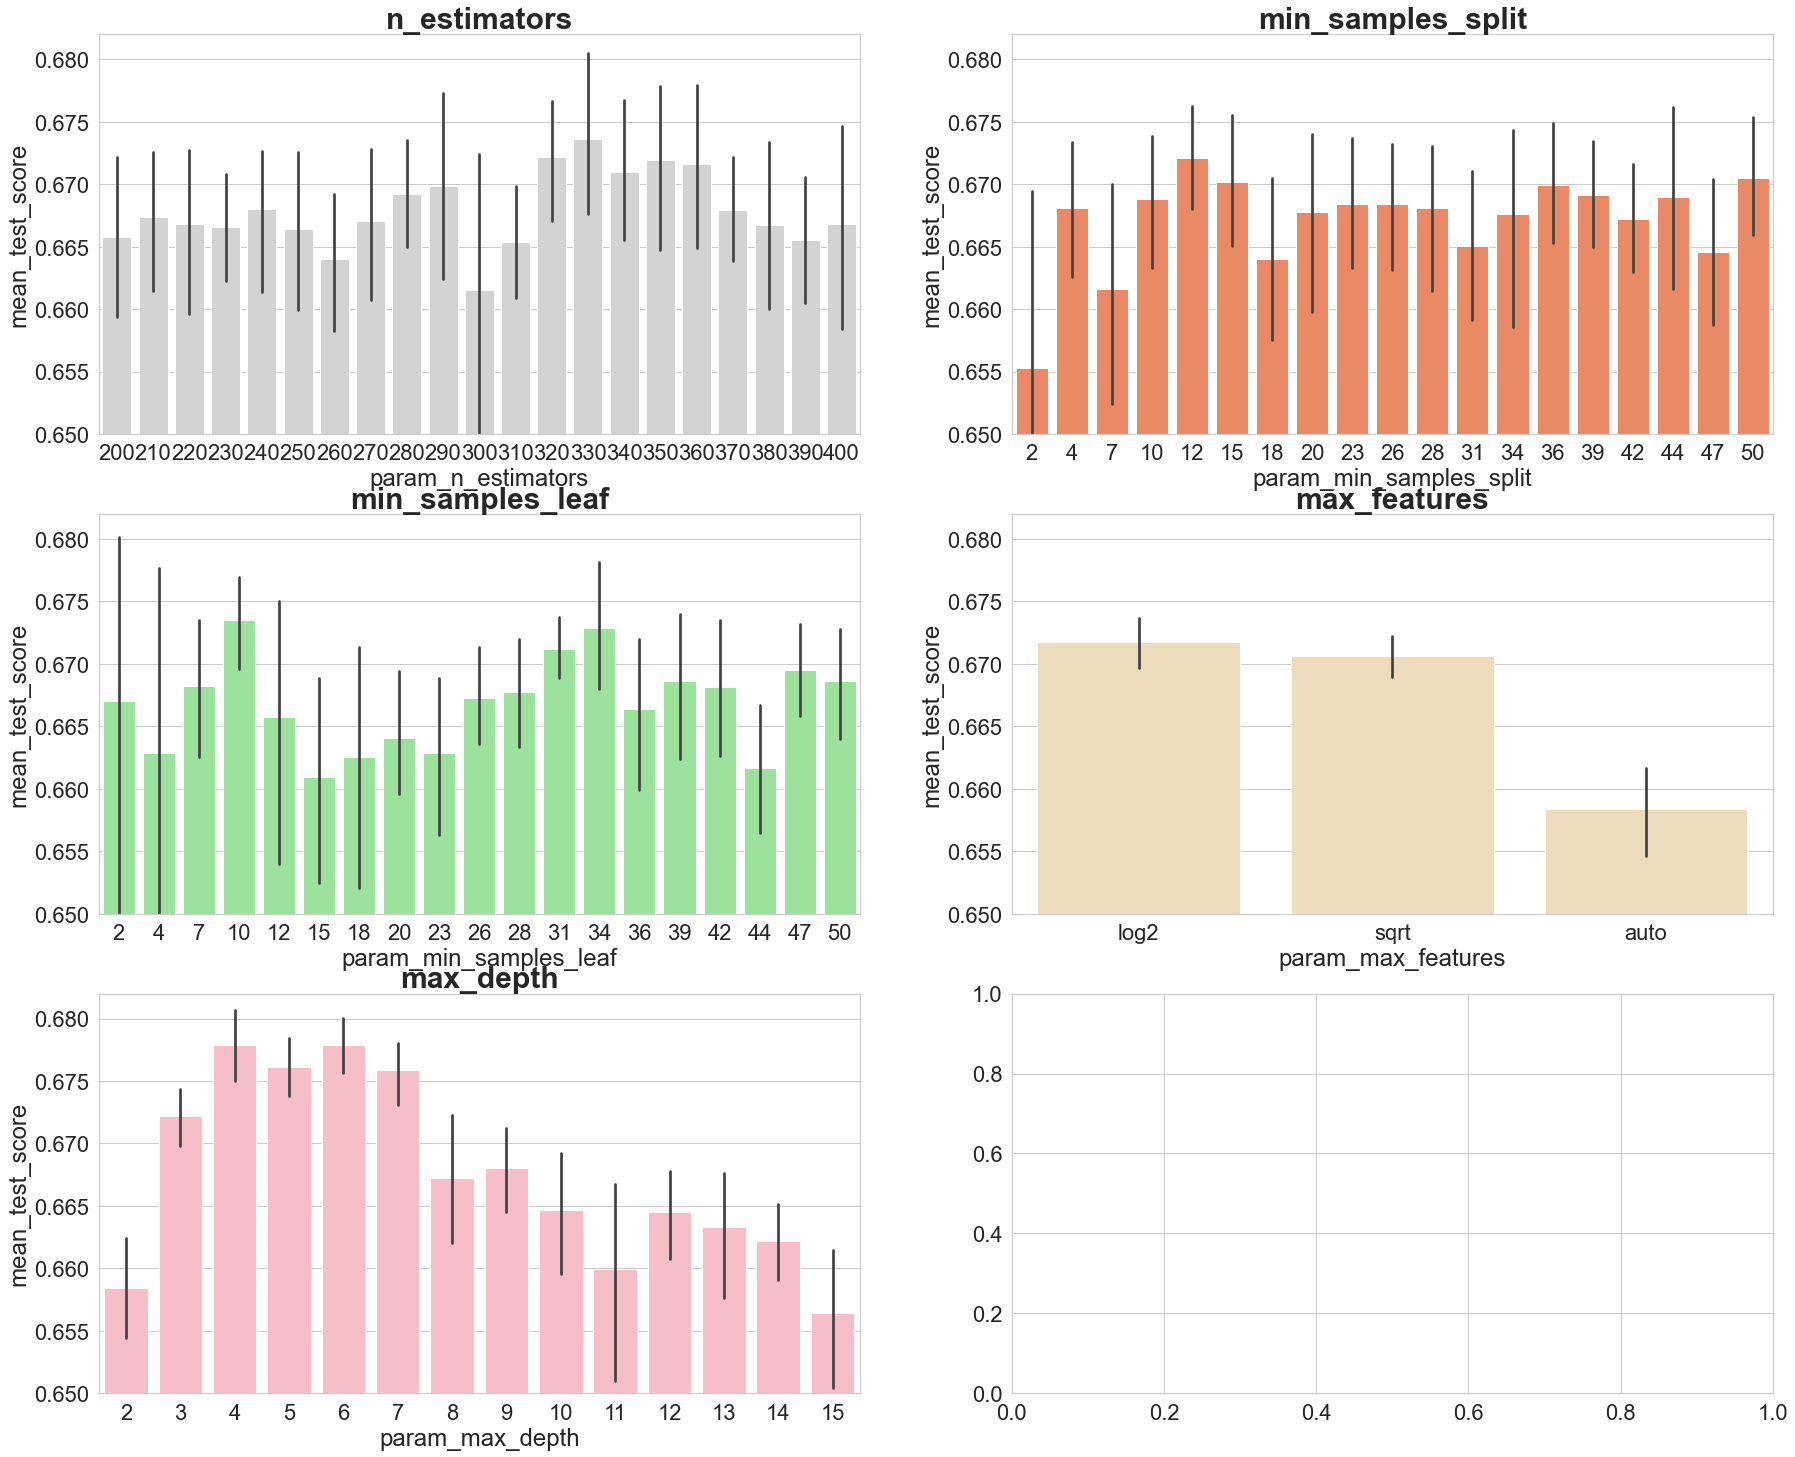

In [82]:
fig, axs = plt.subplots(ncols=2, nrows=3)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.65,.682])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.65,.682])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[1,0], color='lightgreen')
axs[1,0].set_ylim([.65,.682])
axs[1,0].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,1], color='wheat')
axs[1,1].set_ylim([.65,.682])
axs[1,1].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[2,0], color='lightpink')
axs[2,0].set_ylim([.65,.682])
axs[2,0].set_title(label = 'max_depth', size=30, weight='bold')
plt.show()

Изучив графики выше, можно сделать вывод, что одним из лучших параметров для модели GradientBoostingRegressor будет:

     'n_estimators': 330
     'min_samples_split': 12,44
     'min_samples_leaf': 2
     'max_features': 'log2'
     'max_depth': 4,6

In [102]:
model = GradientBoostingRegressor(random_state=12345,n_estimators=330,max_depth=6,min_samples_split=12,
                                  min_samples_leaf=2, max_features='log2')
model.fit(features_train,target_train) 
pred_train = model.predict(features_train)
pred_test = model.predict(features_valid)
print("Accuracy train:", round(r2_score(target_train,pred_train),2))
print("Accuracy test:", round(r2_score(target_valid,pred_test),2))

Accuracy train: 0.91
Accuracy test: 0.74


Показатели качества выросли, но также увеличилась разница между качеством на тесте и трейне, что не очень хорошо для модели. 

Алгоритм RandomizedSearchCV позволяет довольно грубо исследовать широкие диапазоны значений в пользу затраченного времени. Попробуем оптимизировать параметры более сложным алгоритмом GridSearchCV.

In [99]:
# Алгоритм GridSearchCV ниже закоментирован, т.к расчет оптимальных параметров уже проведен и подставален в параметры модели
params = {
    'max_depth': list(range(2, 3)),
    'n_estimators': list(range(50, 51)),
    'min_samples_split': range (2,3),
    'min_samples_leaf': range (1,2)
}

# воспользуемся GridSearchCV для поиска наилучших гиперпараметров
GSCV_model = GridSearchCV(GradientBoostingRegressor(random_state=12345), params, cv=5, verbose=10, n_jobs=-1)
#GSCV_model.fit(features_train, target_train)
#print(f'Параметры наилучшей модели: {GSCV.best_params_}')
#print(f'Accuracy: {GSCV.best_score_}')

Оптимальные параметры:

     'n_estimators': 350
     'min_samples_split': 4
     'min_samples_leaf': 2
     'max_depth': 4

Подставим найденные параметри в модель

In [83]:
model = GradientBoostingRegressor(random_state=12345,n_estimators=350,max_depth=4,min_samples_split=4,min_samples_leaf=2)
model.fit(features_train,target_train) 
pred_train = model.predict(features_train)
pred_test = model.predict(features_valid)
print("Accuracy train:", round(r2_score(target_train,pred_train),2))
print("Accuracy test:", round(r2_score(target_valid,pred_test),2))

Accuracy train: 0.86
Accuracy test: 0.75


После проведения оптимизации значительно повысилась точность модели, на тесте до 0.75, на трейне до 0.86.

### Выявление признаков влияющих на качество модели

In [44]:
feats = {}
metrics = pd.DataFrame(columns=['MAE train', 'MAE test', 'MSE train', 'MSE test', 'R2 train', 'R2 test'])
print('R2 train:',r2_score(target_train, pred_train))
print('R2 test:',r2_score(target_valid, pred_test))
for feature, importance in zip(features.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
metrics = metrics.append({  'MAE train' : mean_absolute_error(target_train, pred_train), 
                            'MAE test' : mean_absolute_error(target_valid, pred_test), 
                            'MSE train' : mean_squared_error(target_train, pred_train), 
                            'MSE test' : mean_squared_error(target_valid, pred_test), 
                            'R2 train' : r2_score(target_train, pred_train), 
                            'R2 test' : r2_score(target_valid, pred_test)}, ignore_index=True)
display(metrics)

R2 train: 0.8626305470037497
R2 test: 0.7456830313907623


,MAE train,MAE test,MSE train,MSE test,R2 train,R2 test
0,1.197633e+06,1.495897e+06,3.471690e+12,6.313977e+12,0.862631,0.745683


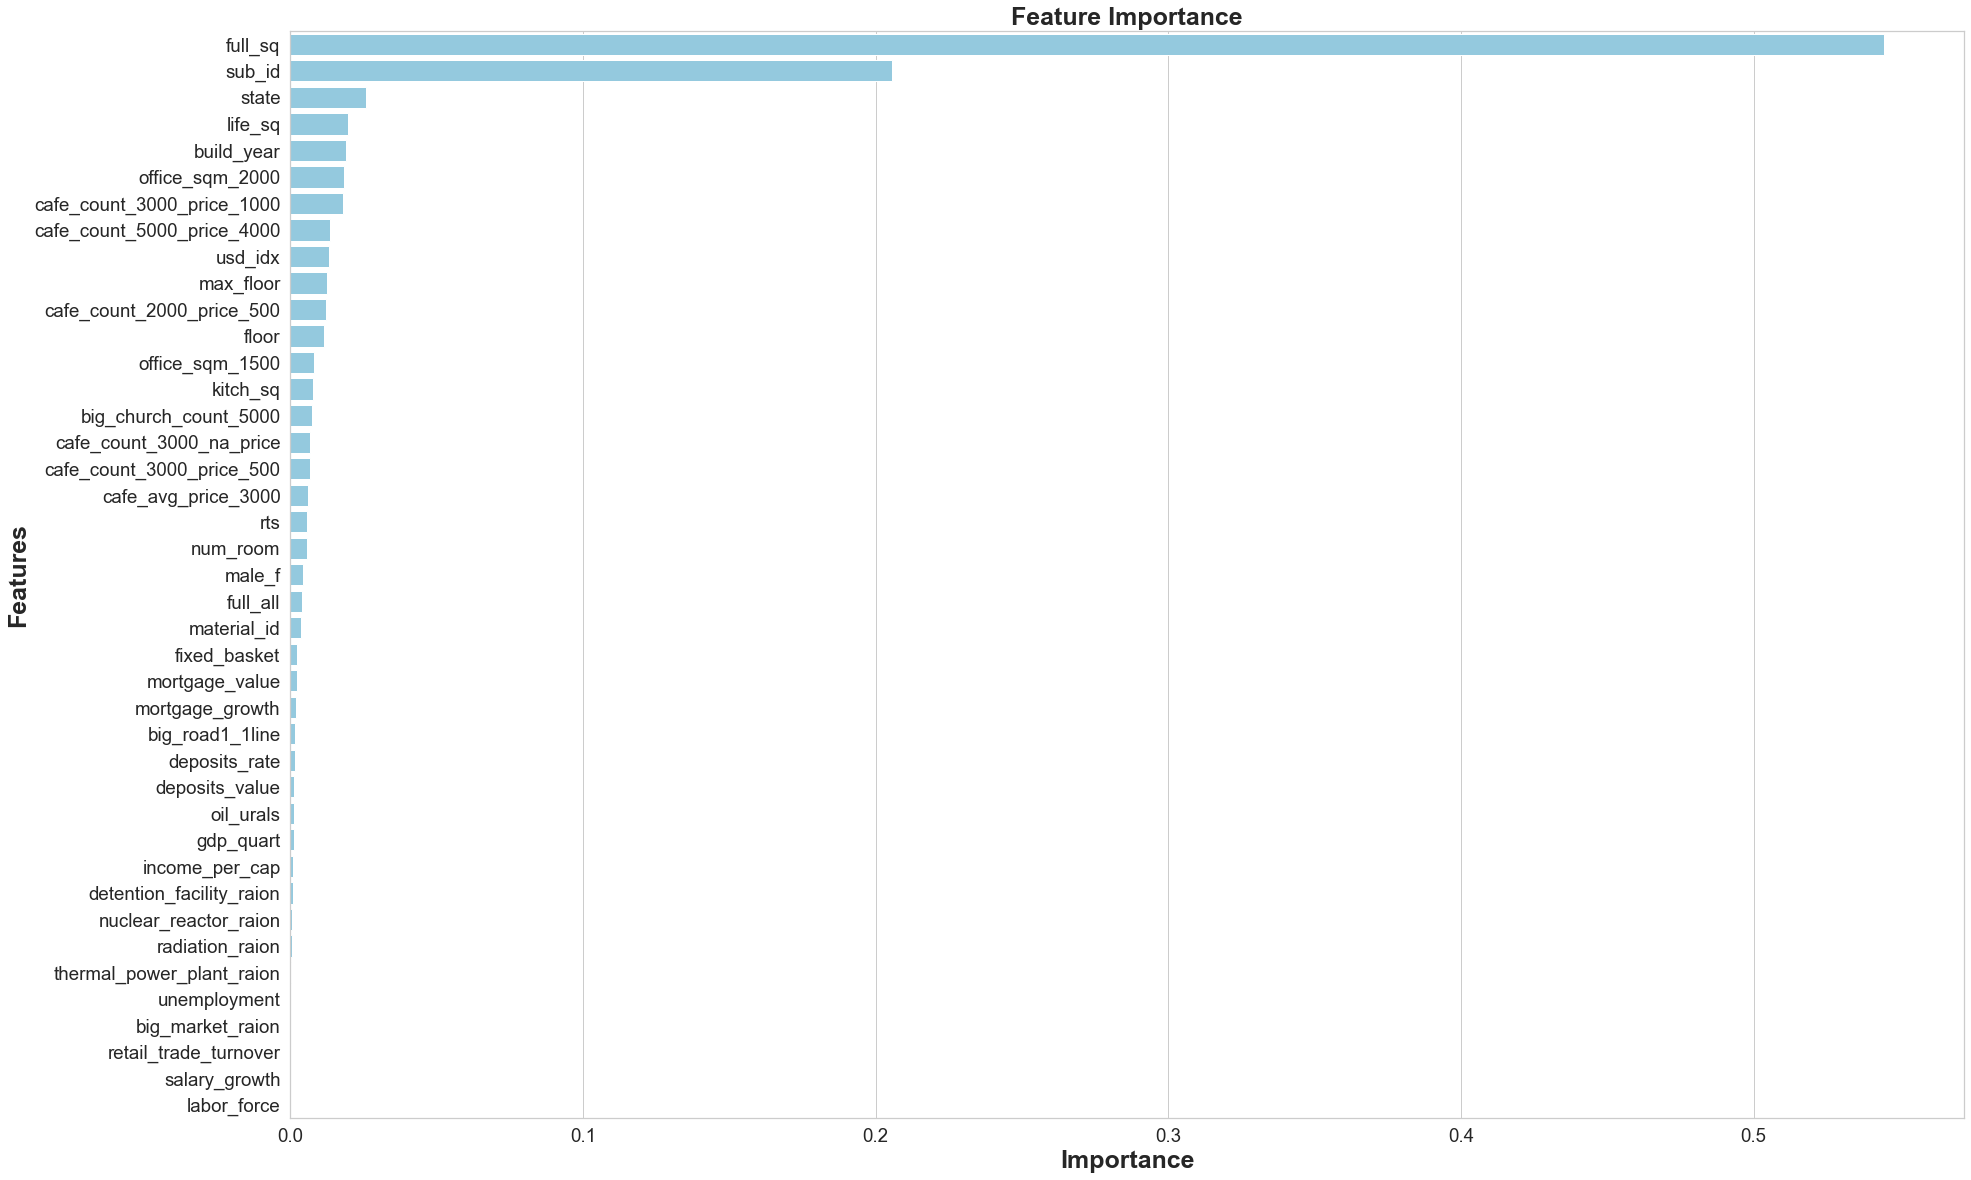

None

In [45]:
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())

In [46]:
display(importances.head(50))

,Features,Gini-Importance
0,full_sq,0.544649
1,sub_id,0.205690
2,state,0.025823
3,life_sq,0.019861
4,build_year,0.019262
5,office_sqm_2000,0.018586
6,cafe_count_3000_price_1000,0.018044
7,cafe_count_5000_price_4000,0.013520
8,usd_idx,0.013380
9,max_floor,0.012639


На основании признаков влияющих на качество модели были убраны неинформативные признаки из датафрейма, что также сказалось на качестве предсказаний модели.

**Вывод:**

Проведена чистка данных (пропуски данных, неинформативные признаки, аномалии, оцифровка текстовых столбцов и т.п.)

Проведен Exploratory Data Analysis. 

В ходе исследования мы обучили и проверили точность трех моделей:

    - XGBRegressor
    - RandomForestRegressor
    - GradientBoostingRegressor

Для решения задачи регрессии предсказаний стоимости недвижимости предлагается использовать модель GradientBoostingRegressor с параметрами: 


    n_estimators: 350
    min_samples_split: 4
    min_samples_leaf: 2
    max_depth: 4
с данными параметрами модель обладает высоким показателем Accuracy т.е. наиболее точно предсказывает стоимость недвижимости при низкой среднеквадратичной ошибке.

Точность итоговой модели составляет: **0.75**